In [2]:
import pandas as pd
import numpy as np
from minisom import MiniSom
import matplotlib.pyplot as plt


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "d:\anaconda\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "d:\anaconda\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "d:\anaconda\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "d:\anaconda\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    app.start()
  File "d:\anaconda\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
    self.io_loop

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "d:\anaconda\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "d:\anaconda\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "d:\anaconda\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "d:\anaconda\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    app.start()
  File "d:\anaconda\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
    self.io_loop

AttributeError: _ARRAY_API not found

In [3]:
np.random.seed(42)

In [4]:
df=pd.read_csv('df_SOM.csv',delimiter=',')

In [5]:
df.set_index('customer_id',inplace=True)

In [6]:
data = df.values

In [11]:
sigma_values = [6]  # Neighborhood size
learning_rate_values = [0.1]  # Learning rate
iteration_values = [70000,150000,200000]  # Training iterations

# Initialize variables to store the best parameters and results
results = []

# Function to calculate quantization error
def calculate_quantization_error(som, data):
    return np.mean([np.linalg.norm(x - som.get_weights()[som.winner(x)]) for x in data])

# Function to calculate topological error
def calculate_topological_error(som, data):
    errors = 0
    grid_shape = som.get_weights().shape[:2]  # Get SOM grid dimensions (x, y)
    for x in data:
        bmu = som.winner(x)  # First BMU
        activation_map = som.activate(x).flatten()
        second_bmu = activation_map.argsort()[1]  # Index of the second BMU
        second_bmu_coords = np.unravel_index(second_bmu, grid_shape)  # Convert to 2D coordinates
        if not (abs(bmu[0] - second_bmu_coords[0]) <= 1 and abs(bmu[1] - second_bmu_coords[1]) <= 1):
            errors += 1
    return errors / len(data)
# Grid search over the parameter space
for sigma in sigma_values:
    for learning_rate in learning_rate_values:
        for iterations in iteration_values:
            print(f"Testing sigma={sigma}, learning_rate={learning_rate}, iterations={iterations}")
            
            # Initialize the SOM
            som = MiniSom(x=29, y=29, input_len=data.shape[1], sigma=sigma, learning_rate=learning_rate)
            som.random_weights_init(data)
            
            # Train the SOM
            som.train_random(data, iterations)
            
            # Evaluate errors
            quantization_error = calculate_quantization_error(som, data)
            topological_error = calculate_topological_error(som, data)
            
            # Store results
            results.append({
                'sigma': sigma,
                'learning_rate': learning_rate,
                'iterations': iterations,
                'quantization_error': quantization_error,
                'topological_error': topological_error
            })

            print(f"Quantization Error: {quantization_error}")
            print(f"Topological Error: {topological_error}")

# Convert results to a DataFrame for analysis
results_df = pd.DataFrame(results)

Testing sigma=6, learning_rate=0.1, iterations=70000


KeyboardInterrupt: 

In [26]:
results_df

,sigma,learning_rate,iterations,quantization_error,topological_error
0,6,0.1,50000,0.216510,0.008477
1,6,0.1,70000,0.211298,0.009590
2,6,0.5,50000,0.217653,0.015055
3,6,0.5,70000,0.213612,0.012601


In [7]:
sm = MiniSom(x=29, y=29, input_len=data.shape[1], sigma=6, learning_rate=0.1,random_seed=42)
sm.random_weights_init(data)
sm.train_random(data, 50000)

In [8]:
## Import Matplotlib functions to create MiniSOM visualizations

from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib import colors as mpl_colors
from matplotlib.colors import LinearSegmentedColormap

from matplotlib.lines import Line2D
import seaborn as sns

from matplotlib import __version__ as mplver

In [14]:
def plot_hexagons(som,              # Trained SOM model 
                  sf,               # matplotlib figure object
                  colornorm,        # colornorm
                  matrix_vals,      # SOM weights or
                  label="",         # title for figure
                  cmap=cm.Grays,    # colormap to use
                  annot=False       
                  ):

    
    axs = sf.subplots(1,1)
    
    for i in range(matrix_vals.shape[0]):
        for j in range(matrix_vals.shape[1]):

            wx, wy = som.convert_map_to_euclidean((i,j)) 

            hex = RegularPolygon((wx, wy), 
                                numVertices=6, 
                                radius= np.sqrt(1/3),
                                facecolor=cmap(colornorm(matrix_vals[i, j])), 
                                alpha=1, 
                                edgecolor='white',
                                linewidth=.5)
            axs.add_patch(hex)
            if annot==True:
                annot_val = np.round(matrix_vals[i,j],2)
                if int(annot_val) == annot_val:
                    annot_val = int(annot_val)
                axs.text(wx,wy, annot_val, 
                        ha='center', va='center', 
                        fontsize='x-small')


    ## Remove axes for hex plot
    axs.margins(.05)
    axs.set_aspect('equal')
    axs.axis("off")
    axs.set_title(label)

    

    # ## Add colorbar
    divider = make_axes_locatable(axs)
    ax_cb = divider.append_axes("right", size="5%", pad="0%")

    ## Create a Mappable object
    cmap_sm = plt.cm.ScalarMappable(cmap=cmap, norm=colornorm)
    cmap_sm.set_array([])

    ## Create custom colorbar 
    cb1 = colorbar.Colorbar(ax_cb,
                            orientation='vertical', 
                            alpha=1,
                            mappable=cmap_sm
                            )
    cb1.ax.get_yaxis().labelpad = 6

    # Add colorbar to plot
    sf.add_axes(ax_cb)




    return sf 

In [9]:
weights = sm.get_weights()
weights.shape

(29, 29, 44)

In [11]:
metric_features=df.columns

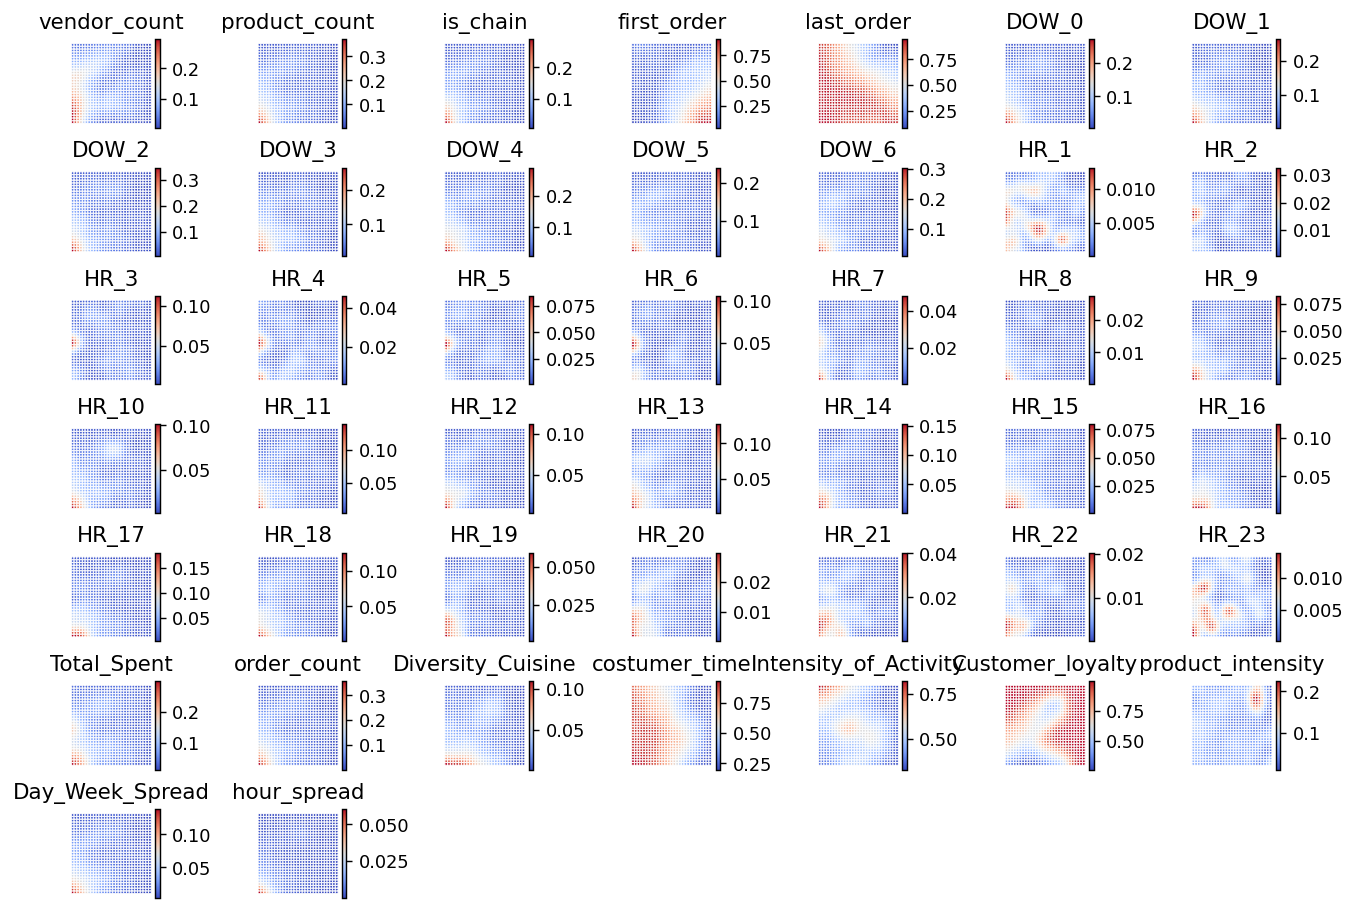

In [19]:
figsize=(10,7)
fig = plt.figure(figsize=figsize, constrained_layout=True, dpi=128, )

subfigs = fig.subfigures(7,7,wspace=.15)

colornorm = mpl_colors.Normalize(vmin=np.min(weights), vmax=np.max(weights))

for cpi, sf in zip(range(len(metric_features)), subfigs.flatten()):
    
    matrix_vals = weights[:,:,cpi]
    vext = np.max(np.abs([np.min(matrix_vals), np.max(matrix_vals)]))
    colornorm = mpl_colors.Normalize(vmin=np.min(matrix_vals), vmax=np.max(matrix_vals))
    # colornorm = mpl_colors.CenteredNorm(vcenter=0, halfrange=vext)


    sf = plot_hexagons(sm, sf, 
                    colornorm,
                    matrix_vals,
                    label=metric_features[cpi],
                    cmap=cm.coolwarm,
                    )

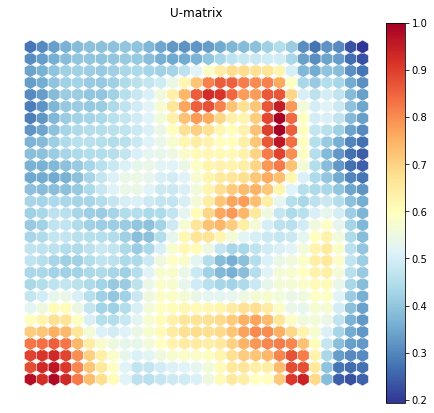

In [20]:
umatrix = sm.distance_map(scaling='mean')
fig = plt.figure(figsize=figsize)

colornorm = mpl_colors.Normalize(vmin=np.min(umatrix), vmax=np.max(umatrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    umatrix,
                    label="U-matrix",
                    cmap=cm.RdYlBu_r,
                    )

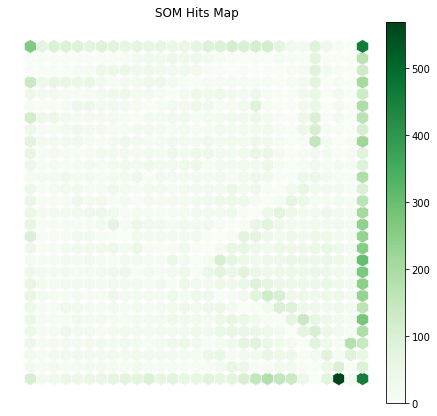

In [21]:
hitsmatrix = sm.activation_response(df[metric_features].values)


fig = plt.figure(figsize=figsize)

colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(hitsmatrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    hitsmatrix,
                    label="SOM Hits Map",
                    cmap=cm.Greens,
                    )